In [40]:
import shutil
import os

shutil.rmtree('/kaggle/working/checkpoints', ignore_errors=True)
print("Saved files:", os.listdir('/kaggle/working/'))

Saved files: ['.virtual_documents', 'dev-clean.tar.gz', 'clean_speech', 'noise', 'ESC-50-master.zip']


In [1]:
!pip install pesq

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp311-cp311-linux_x86_64.whl size=275941 sha256=1a8a738c916cf299001a0c6bd40f96bcaab0090387ffbe9ddacb1176c208795d
  Stored in directory: /root/.cache/pip/wheels/ae/f1/23/2698d0bf31eec2b2aa50623b5d93b6206c49c7155d0e31345d
Successfully built pesq


In [ ]:
%env TORCH_NCCL_BLOCKING_WAIT=1
%env TORCH_NCCL_ASYNC_ERROR_HANDLING=1
%env TORCH_NCCL_DEBUG=INFO
%env TORCH_NCCL_IB_DISABLE=1
%env TORCH_NCCL_TIMEOUT=3600

### Specially for 100 000 data

In [2]:
!python /kaggle/input/ddp-gan-diploma/train_ddp.py --epochs 5 --nb_samples 100000 --download 1

--2025-05-12 09:01:42--  http://openslr.elda.org/resources/12/dev-clean.tar.gz
Resolving openslr.elda.org (openslr.elda.org)... 141.94.109.138, 2001:41d0:203:ad8a::
Connecting to openslr.elda.org (openslr.elda.org)|141.94.109.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337926286 (322M) [application/x-gzip]
Saving to: ‘/kaggle/working/dev-clean.tar.gz’

/kaggle/working/dev 100%[===================>] 322.27M  18.9MB/s    in 17s     

2025-05-12 09:02:00 (18.8 MB/s) - ‘/kaggle/working/dev-clean.tar.gz’ saved [337926286/337926286]

LibriSpeech/LICENSE.TXT
LibriSpeech/README.TXT
LibriSpeech/CHAPTERS.TXT
LibriSpeech/SPEAKERS.TXT
LibriSpeech/BOOKS.TXT
LibriSpeech/dev-clean/
LibriSpeech/dev-clean/2277/
LibriSpeech/dev-clean/2277/149896/
LibriSpeech/dev-clean/2277/149896/2277-149896-0026.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0005.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0033.flac
LibriSpeech/dev-clean/2277/149896/2277-149896-0006.flac
Libr

In [19]:
 !python /kaggle/input/ddp-gan-diploma/train_ddp.py --epochs 50 --nb_samples 5000 --download 0

Noisy spectrogram batch: torch.Size([16, 1, 128, 128])
Clean spectrogram batch: torch.Size([16, 1, 128, 128])
[rank1]:[W512 00:00:32.388475786 Utils.hpp:110] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING is deprecated; use TORCH_NCCL_ASYNC_ERROR_HANDLING instead (function operator())
[rank0]:[W512 00:00:32.388554511 Utils.hpp:110] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING is deprecated; use TORCH_NCCL_ASYNC_ERROR_HANDLING instead (function operator())
Epoch 1: 100%|███████████████████| 250/250 [00:54<00:00,  4.59it/s, Loss=0.0369]
PESQ failed: b'No utterances detected'
PESQ failed: b'No utterances detected'
PESQ failed: b'No utterances detected'
PESQ failed: b'No utterances detected'
[Epoch 1] Val MAE: 0.0349 | PSNR: 26.61 | SSIM: 0.721 | PESQ: 1.543 (from 996 samples)
Epoch 2: 100%|████████████████████| 250/250 [00:52<00:00,  4.77it/s, Loss=0.028]
PESQ failed: b'No utterances detected'
[Epoch 2] Val MAE: 0.0288 | PSNR: 27.86 | SSIM: 0.774 | PESQ: 1.622 (from 99

In [3]:
import os
print("Saved files:", os.listdir('/kaggle/working/checkpoints'))

Saved files: ['ckpt_epoch1.pth', 'ckpt_epoch3.pth', 'history.json', 'best_model.pth', 'ckpt_epoch2.pth', 'ckpt_epoch4.pth', 'ckpt_epoch0.pth']


In [4]:
import os
import random
import shutil
import subprocess
import warnings

import numpy as np
import pandas as pd
import librosa
import soundfile as sf
from pesq import pesq

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.distributed import DistributedSampler

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

import IPython
import json
import argparse
import math
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key_conv   = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim,     kernel_size=1)
        self.gamma      = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch, C, H, W = x.size()
        proj_query = self.query_conv(x).view(batch, -1, H*W).permute(0, 2, 1)
        proj_key   = self.key_conv(x).view(batch, -1, H*W)
        energy     = torch.bmm(proj_query, proj_key)
        attention  = F.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(batch, -1, H*W)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch, C, H, W)
        return self.gamma * out + x


class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(
                nn.Sequential(
                    nn.BatchNorm2d(in_channels + i * growth_rate),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels + i * growth_rate, growth_rate, kernel_size=3, padding=1)
                )
            )

    def forward(self, x):
        features = [x]
        for layer in self.layers:
            out = layer(torch.cat(features, 1))
            features.append(out)
        return torch.cat(features, 1)


class TFDenseUNetGenerator(nn.Module):
    def __init__(self, in_channels=1, base_channels=32, growth_rate=16, num_layers=4):
        super().__init__()
        self.enc1 = DenseBlock(in_channels, growth_rate, num_layers)
        enc1_out = in_channels + num_layers * growth_rate
        self.down1 = nn.Conv2d(enc1_out, base_channels, kernel_size=4, stride=2, padding=1)

        self.enc2 = DenseBlock(base_channels, growth_rate, num_layers)
        enc2_out = base_channels + num_layers * growth_rate
        self.down2 = nn.Conv2d(enc2_out, base_channels*2, kernel_size=4, stride=2, padding=1)

        self.enc3 = DenseBlock(base_channels*2, growth_rate, num_layers)
        enc3_out = base_channels*2 + num_layers * growth_rate
        self.down3 = nn.Conv2d(enc3_out, base_channels*4, kernel_size=4, stride=2, padding=1)

        self.bottleneck = DenseBlock(base_channels*4, growth_rate, num_layers)
        bottleneck_out = base_channels*4 + num_layers * growth_rate
        self.attn = SelfAttention(bottleneck_out)

        self.up3 = nn.ConvTranspose2d(bottleneck_out, base_channels*2, kernel_size=4, stride=2, padding=1)
        dec3_in = base_channels*2 + enc3_out
        self.dec3 = DenseBlock(dec3_in, growth_rate, num_layers)
        dec3_out = dec3_in + num_layers * growth_rate

        self.up2 = nn.ConvTranspose2d(dec3_out, base_channels, kernel_size=4, stride=2, padding=1)
        dec2_in = base_channels + enc2_out
        self.dec2 = DenseBlock(dec2_in, growth_rate, num_layers)
        dec2_out = dec2_in + num_layers * growth_rate

        self.up1 = nn.ConvTranspose2d(dec2_out, base_channels, kernel_size=4, stride=2, padding=1)
        dec1_in = base_channels + enc1_out
        self.dec1 = DenseBlock(dec1_in, growth_rate, num_layers)
        dec1_out = dec1_in + num_layers * growth_rate

        self.final_conv = nn.Conv2d(dec1_out, in_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        d1 = self.down1(e1)

        e2 = self.enc2(d1)
        d2 = self.down2(e2)

        e3 = self.enc3(d2)
        d3 = self.down3(e3)

        b = self.bottleneck(d3)
        b = self.attn(b)

        u3 = self.up3(b)
        cat3 = torch.cat([u3, e3], dim=1)
        dec3 = self.dec3(cat3)

        u2 = self.up2(dec3)
        cat2 = torch.cat([u2, e2], dim=1)
        dec2 = self.dec2(cat2)

        u1 = self.up1(dec2)
        cat1 = torch.cat([u1, e1], dim=1)
        dec1 = self.dec1(cat1)

        out = self.final_conv(dec1)
        return out

class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=1, base_channels=64):
        super().__init__()
        layers = []
        layers.append(nn.Conv2d(in_channels, base_channels, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        ch = base_channels
        for i in range(1, 5):
            layers.append(nn.Conv2d(ch, ch*2, kernel_size=4, stride=2, padding=1))
            layers.append(nn.InstanceNorm2d(ch*2))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            ch *= 2
        layers.append(nn.Conv2d(ch, 1, kernel_size=4, padding=1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class MultiScaleDiscriminator(nn.Module):
    def __init__(self, num_scales=3):
        super().__init__()
        self.discriminators = nn.ModuleList([
            PatchGANDiscriminator() for _ in range(num_scales)
        ])
        self.downsample = nn.AvgPool2d(3, stride=2, padding=[1,1], count_include_pad=False)

    def forward(self, x):
        results = []
        for D in self.discriminators:
            results.append(D(x))
            x = self.downsample(x)
        return results

In [5]:
warnings.filterwarnings("ignore", category=FutureWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TFDenseUNetGenerator().to(device)

CONFIG = {
    "sample_rate": 8000,
    "frame_length": 8064,
    "hop_length_frame": 8000,
    "n_fft": 255,
    "hop_length_fft": 63,
    "batch_size_per_gpu": 8,
    "lr": 1e-4,
    "noise_levels": (0.2, 0.8),
    "checkpoint_dir": "/kaggle/working/checkpoints"
}

checkpoint_path = os.path.join(CONFIG["checkpoint_dir"], "best_model.pth")

checkpoint = torch.load(checkpoint_path)
# checkpoint = torch.load("/kaggle/working/checkpoints/ckpt_epoch0.pth")
# Load model weights
model.load_state_dict(checkpoint["model_state"])

start_epoch = checkpoint.get("epoch", 0)
best_mae = checkpoint.get("best_mae", float("inf"))
metrics = checkpoint.get("metrics", {})
history = checkpoint.get("history", {
    "val_mae": [], "val_psnr": [], "val_ssim": [], "val_pesq": []
})

print(f"Loaded best model from epoch {start_epoch+1} with MAE: {best_mae:.4f}")

Loaded best model from epoch 5 with MAE: 0.0107


In [6]:
print(metrics)

{'mae': 0.010690253101289272, 'psnr': 31.242834410987452, 'ssim': 0.9192150987499402, 'pesq': 1.8475735898078345}


In [7]:

def list_audio_files(folder, exts=(".wav", ".flac")):
    return [os.path.join(folder, f)
            for f in os.listdir(folder)
            if f.lower().endswith(exts)]

def frame_audio(y, frame_length, hop_length):
    n_frames = 1 + (len(y) - frame_length) // hop_length
    return np.stack([
        y[i*hop_length : i*hop_length + frame_length]
        for i in range(n_frames)
    ], axis=0)

def compute_mag_spectrogram(frame, n_fft, hop_length):
    S = librosa.stft(frame, n_fft=n_fft, hop_length=hop_length, center=False)
    return np.abs(S)

def pad_to_multiple(spec: np.ndarray, mult=8) -> np.ndarray:
     F, T = spec.shape
     pad_F = (mult - (F % mult)) % mult
     pad_T = (mult - (T % mult)) % mult
     if pad_F or pad_T:
         spec = np.pad(
             spec,
             ((0, pad_F), (0, pad_T)),
             mode="reflect"
         )
     return spec

class AudioDenoiseDataset(Dataset):
    def __init__(self,
                 clean_folder,
                 noise_folder,
                 sample_rate=8000,
                 frame_length=8064,
                 hop_length_frame=8064,
                 n_fft=255,
                 hop_length_fft=63,
                 nb_samples=1000,
                 noise_levels=(0.2,0.8)):
        super().__init__()
        self.clean_files = list_audio_files(clean_folder)
        self.noise_files = list_audio_files(noise_folder)
        self.sr = sample_rate
        self.frame_len = frame_length
        self.hop_len_frame = hop_length_frame
        self.n_fft = n_fft
        self.hop_fft = hop_length_fft
        self.nb_samples = nb_samples
        self.noise_levels = noise_levels

    def __len__(self):
        return self.nb_samples

    def __getitem__(self, idx):
        clean_path = random.choice(self.clean_files)
        noise_path = random.choice(self.noise_files)

        clean_y, _ = librosa.load(clean_path, sr=self.sr)
        noise_y, _ = librosa.load(noise_path, sr=self.sr)

        clean_frames = frame_audio(clean_y, self.frame_len, self.hop_len_frame)
        noise_frames = frame_audio(noise_y, self.frame_len, self.hop_len_frame)

        c = clean_frames[np.random.randint(len(clean_frames))]
        n = noise_frames[np.random.randint(len(noise_frames))]

        level = np.random.uniform(*self.noise_levels)
        noisy = c + level * n

        spec_c = compute_mag_spectrogram(c, self.n_fft, self.hop_fft)
        spec_n = compute_mag_spectrogram(noisy, self.n_fft, self.hop_fft)

        def norm(x):
            x = np.log1p(x)
            x = x / np.max(np.abs(x))
            return x.astype(np.float32)
        spec_c = norm(spec_c)
        spec_n = norm(spec_n)

        def pad_to_multiple(spec, mult=8):
            F, T = spec.shape
            pad_F = (mult - (F % mult)) % mult
            pad_T = (mult - (T % mult)) % mult
            if pad_F or pad_T:
                spec = np.pad(spec,
                              ((0, pad_F), (0, pad_T)),
                              mode="reflect")
            return spec

        spec_c = pad_to_multiple(spec_c, mult=8)
        spec_n = pad_to_multiple(spec_n, mult=8)

        return (
            torch.from_numpy(spec_n)[None, ...],
            torch.from_numpy(spec_c)[None, ...],
            noisy.astype(np.float32),
            c.astype(np.float32),
        )


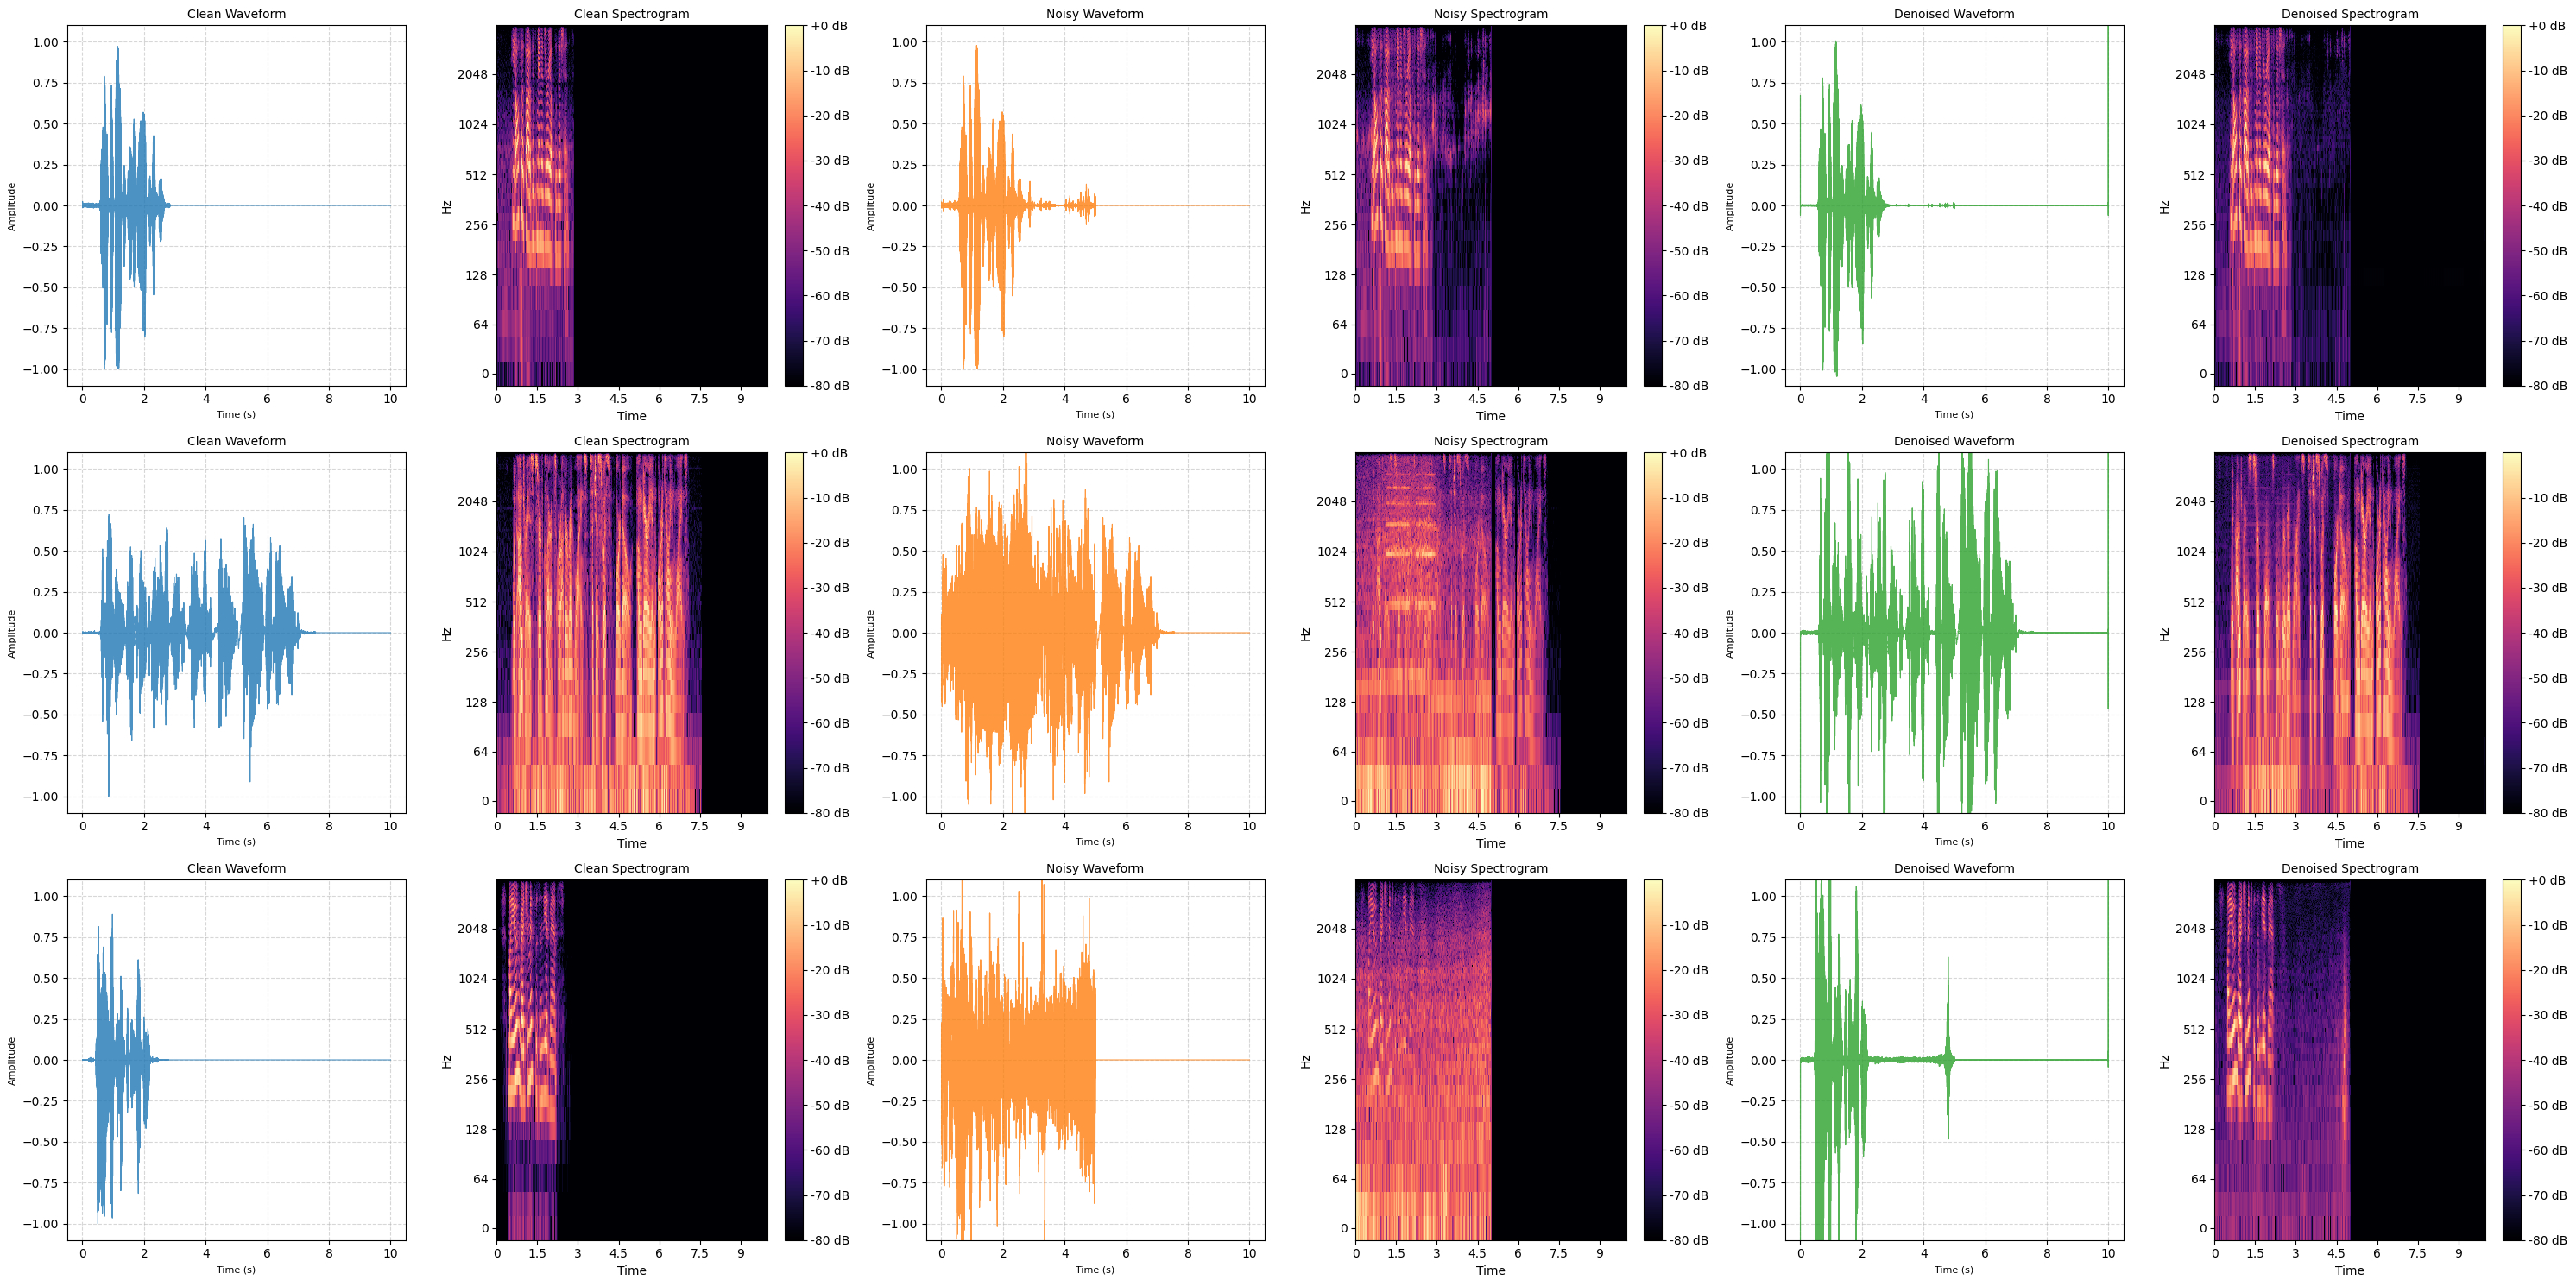


Sample 1 Results:
 PESQ Score: 3.08
=== Clean Audio ===


=== Noisy Audio ===


=== Denoised Audio ===



Sample 2 Results:
 PESQ Score: 2.27
=== Clean Audio ===


=== Noisy Audio ===


=== Denoised Audio ===



Sample 3 Results:
 PESQ Score: 2.69
=== Clean Audio ===


=== Noisy Audio ===


=== Denoised Audio ===


In [8]:
from IPython.display import Audio
clean_dir = "/kaggle/working/clean_speech"
noise_dir = "/kaggle/working/noise"

def visualize_denoising_sample(model, dataset, device, num_samples=3, duration=10):
    model.eval()
    sr = dataset.sr
    n_fft = dataset.n_fft
    hop_fft = dataset.hop_fft
    target_len = int(duration * sr)

    fig, axs = plt.subplots(num_samples, 6, figsize=(30, num_samples*5))
    
    results = []
    
    for i in range(num_samples):
        clean_path = random.choice(dataset.clean_files)
        noise_path = random.choice(dataset.noise_files)
        
        clean, _ = librosa.load(clean_path, sr=sr)
        clean = clean[:target_len] if len(clean) >= target_len else np.pad(clean, (0, target_len - len(clean)))
        
        noise, _ = librosa.load(noise_path, sr=sr)
        noise = noise[:target_len] if len(noise) >= target_len else np.pad(noise, (0, target_len - len(noise)))
        
        level = np.random.uniform(*dataset.noise_levels)
        noisy = clean + level * noise

        S_clean = librosa.stft(clean, n_fft=n_fft, hop_length=hop_fft, center=False)
        S_noisy = librosa.stft(noisy, n_fft=n_fft, hop_length=hop_fft, center=False)
        phase = np.angle(S_noisy)
        
        with torch.no_grad():
            mag_noisy = np.abs(S_noisy)
            log_mag = np.log1p(mag_noisy)
            max_val = np.max(np.abs(log_mag)) + 1e-9
            log_mag_norm = log_mag / max_val
            
            F, T = log_mag_norm.shape
            log_mag_padded = pad_to_multiple(log_mag_norm, mult=8)
            
            input_tensor = torch.from_numpy(log_mag_padded).unsqueeze(0).unsqueeze(0).float().to(device)
            
            output = model(input_tensor)
            
            denoised_log_norm = output.squeeze().cpu().numpy()
            denoised_log = denoised_log_norm * max_val
            mag_denoised = np.exp(denoised_log) - 1
            
            mag_denoised = mag_denoised[:F, :T]
        
        denoised_stft = mag_denoised * np.exp(1j * phase)
        denoised = librosa.istft(denoised_stft, hop_length=hop_fft, center=False)
        denoised = np.pad(denoised, (0, target_len - len(denoised)))[:target_len]

        try:
            pesq_score = pesq(sr, clean, denoised, 'nb')
        except Exception as e:
            pesq_score = None
            print(f"PESQ calculation failed for sample {i+1}: {str(e)}")

        results.append({
            'clean': clean,
            'noisy': noisy,
            'denoised': denoised,
            'pesq': pesq_score
        })

        time = np.linspace(0, duration, target_len)
        max_clean = np.max(np.abs(clean)) + 1e-9
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        
        for j, (sig, title) in enumerate(zip(
            [clean, noisy, denoised],
            ["Clean", "Noisy", "Denoised"]
        )):
            ax = axs[i, j*2]
            ax.plot(time, sig/max_clean, 
                   color=colors[j],
                   linewidth=0.8,
                   alpha=0.8)
            ax.set_ylim(-1.1, 1.1)
            ax.set_xlabel('Time (s)', fontsize=8)
            ax.set_ylabel('Amplitude', fontsize=8)
            ax.set_title(f"{title} Waveform", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.5)
            
            ax = axs[i, j*2+1]
            S = librosa.amplitude_to_db(np.abs(librosa.stft(sig, n_fft=n_fft)), 
                                      ref=np.max)
            img = librosa.display.specshow(S, 
                                         sr=sr, 
                                         hop_length=hop_fft,
                                         x_axis='time', 
                                         y_axis='log',
                                         ax=ax,
                                         cmap='magma')
            ax.set_title(f"{title} Spectrogram", fontsize=10)
            fig.colorbar(img, ax=ax, format='%+2.0f dB')

    plt.tight_layout()
    plt.savefig("100 000 data, 5 epochs 16 bs 2 GPU DDP.png", dpi=300)
    plt.show()
    
    for idx, result in enumerate(results):
        max_audio = np.max(np.abs(result['clean']))
        print(f"\nSample {idx+1} Results:")
        if result['pesq'] is not None:
            print(f" PESQ Score: {result['pesq']:.2f}")
        
        for key in ['clean', 'noisy', 'denoised']:
            print(f"=== {key.capitalize()} Audio ===")
            display(Audio(result[key]/max_audio, rate=sr))


dataset = AudioDenoiseDataset(
    clean_folder=clean_dir,
    noise_folder=noise_dir,
    sample_rate=8000,
    frame_length=8064,
    hop_length_frame=8000,
    n_fft=255,
    hop_length_fft=63,
    nb_samples=50,
    noise_levels=(0.2, 0.8),
)

visualize_denoising_sample(model, dataset, device, num_samples=3, duration=10)

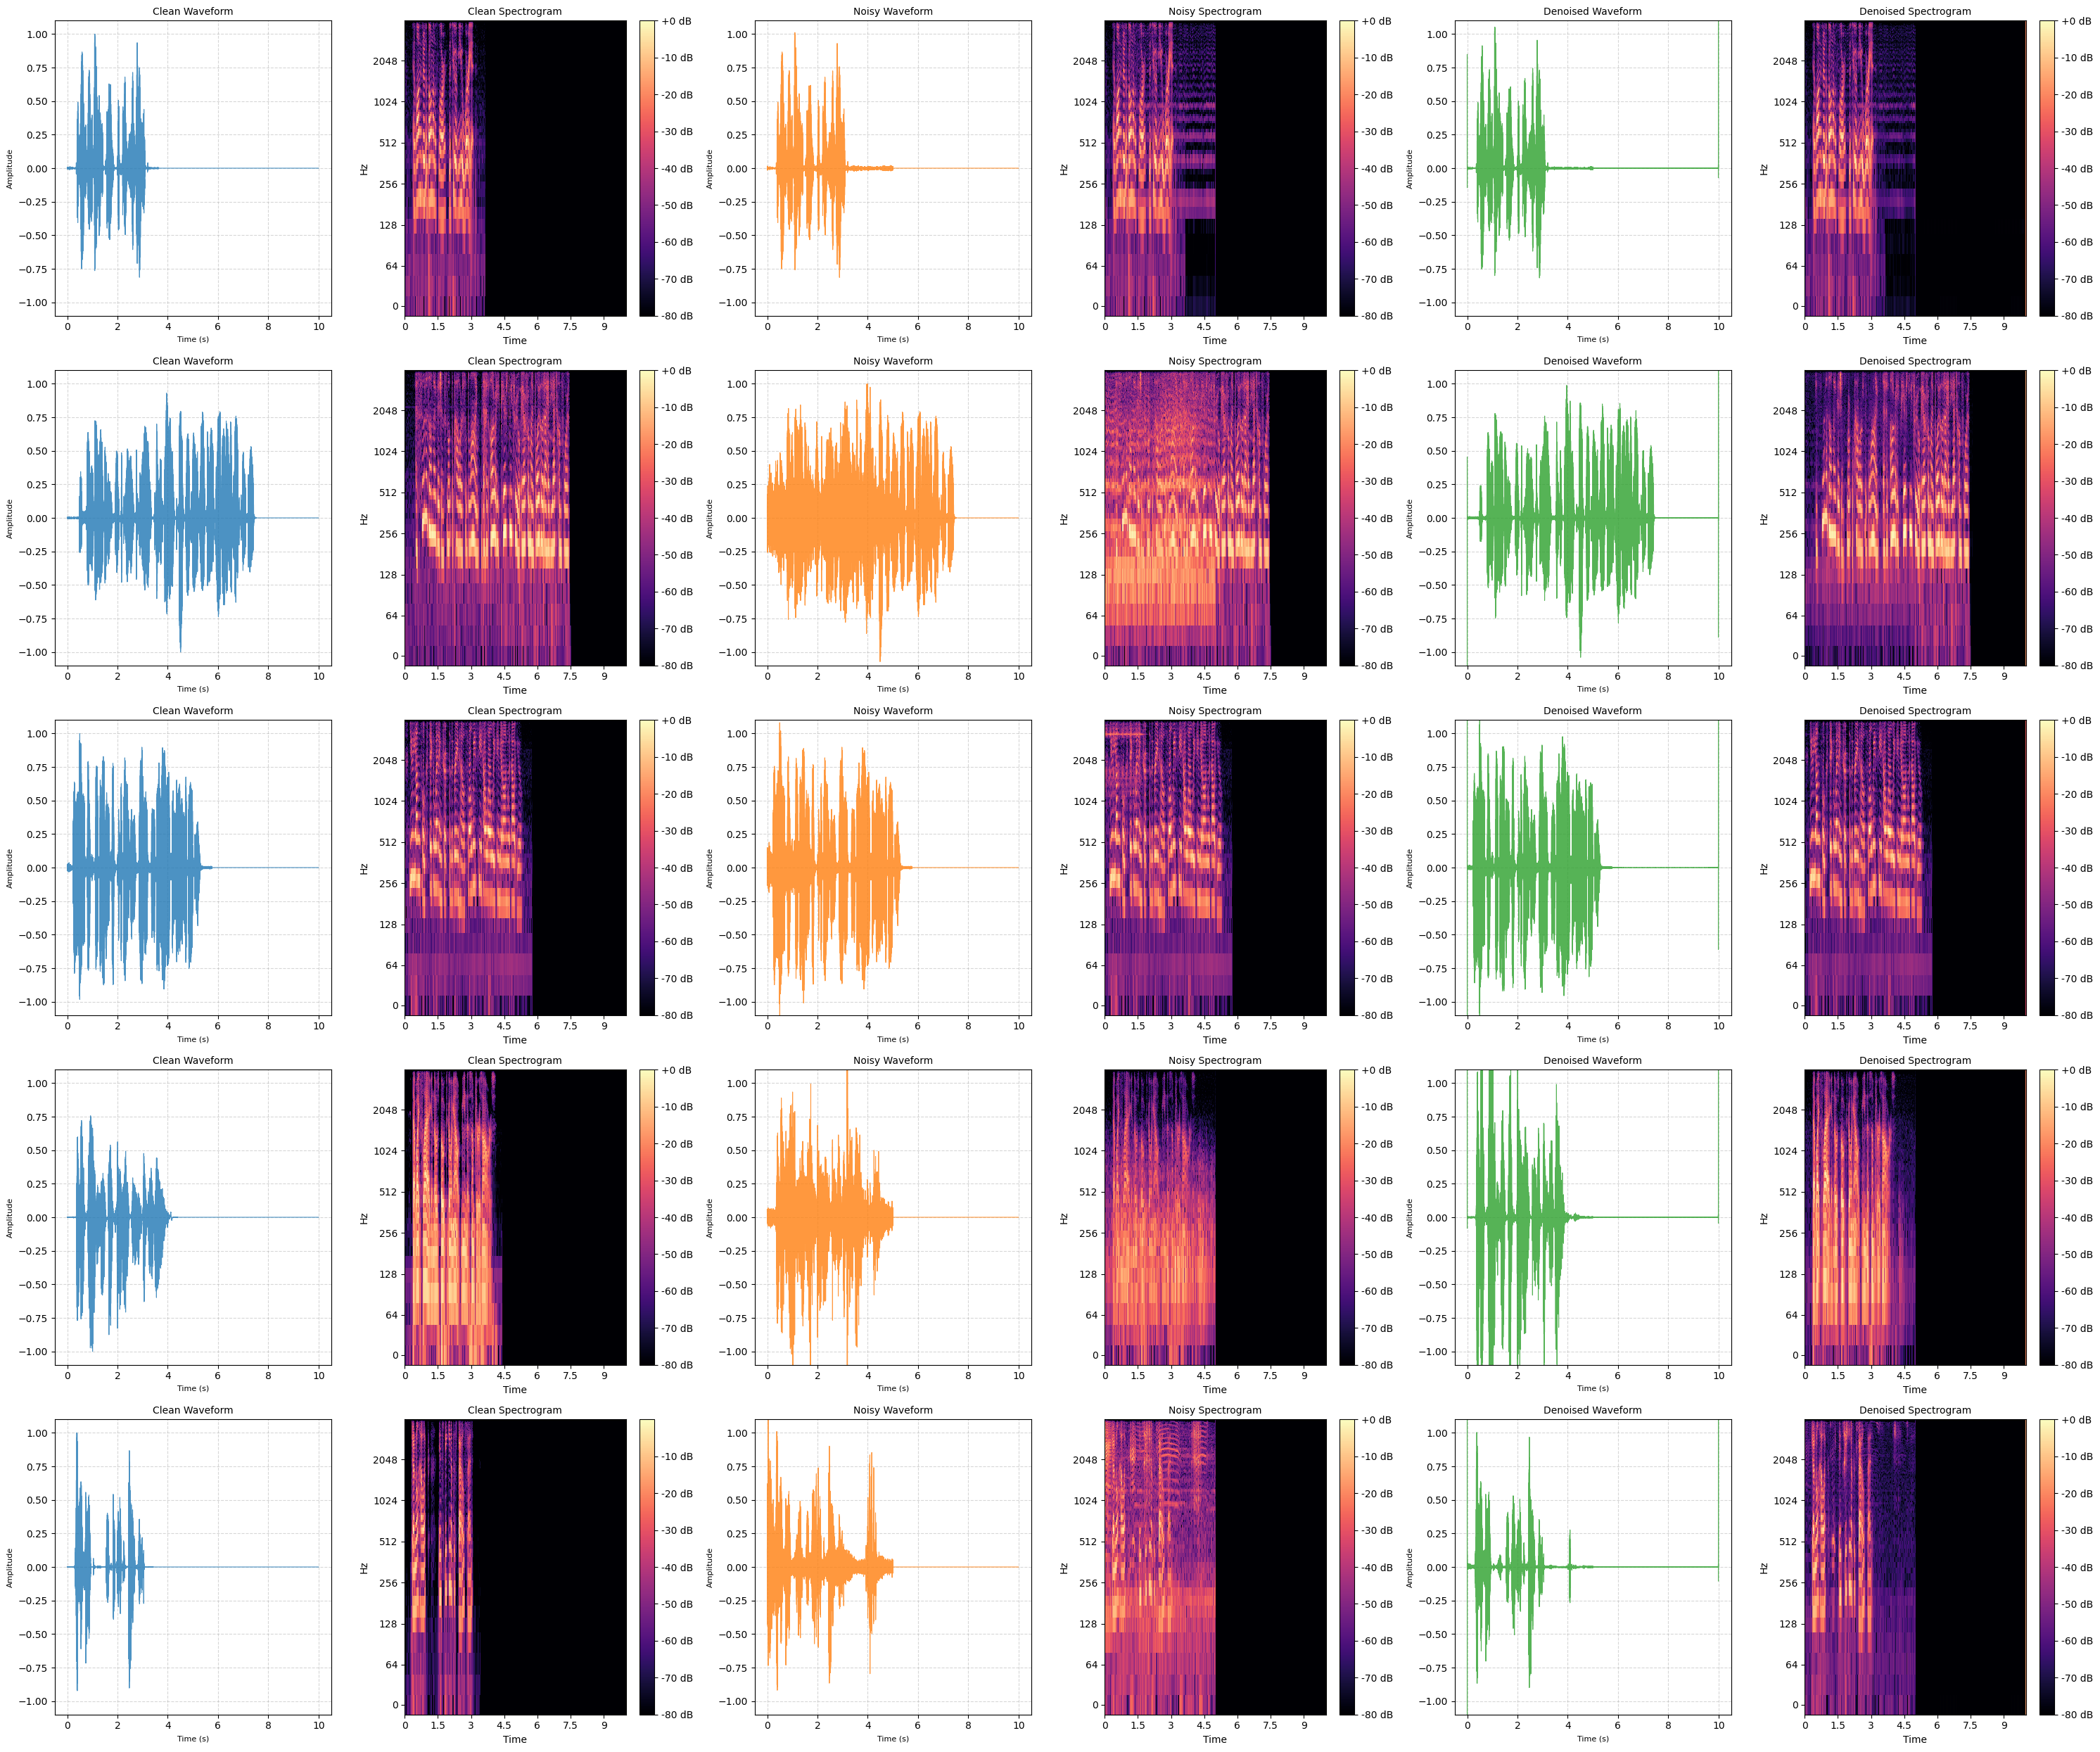


Sample 1 Results:
 PESQ Score: 3.49
=== Clean Audio ===


=== Noisy Audio ===


=== Denoised Audio ===



Sample 2 Results:
 PESQ Score: 2.79
=== Clean Audio ===


=== Noisy Audio ===


=== Denoised Audio ===



Sample 3 Results:
 PESQ Score: 4.25
=== Clean Audio ===


=== Noisy Audio ===


=== Denoised Audio ===



Sample 4 Results:
 PESQ Score: 2.56
=== Clean Audio ===


=== Noisy Audio ===


=== Denoised Audio ===



Sample 5 Results:
 PESQ Score: 2.55
=== Clean Audio ===


=== Noisy Audio ===


=== Denoised Audio ===


In [9]:
visualize_denoising_sample(model, dataset, device, num_samples=5, duration=10)

In [10]:
SAVE_ROOT = "/kaggle/working/checkpoints"
print("Saved files:", os.listdir(SAVE_ROOT))
!zip -r /kaggle/working/checkpoints.zip {SAVE_ROOT}
print("Zipped:", os.path.exists("/kaggle/working/checkpoints.zip"))

Saved files: ['ckpt_epoch1.pth', 'ckpt_epoch3.pth', 'history.json', 'best_model.pth', 'ckpt_epoch2.pth', 'ckpt_epoch4.pth', 'ckpt_epoch0.pth']
  adding: kaggle/working/checkpoints/ (stored 0%)
  adding: kaggle/working/checkpoints/ckpt_epoch1.pth (deflated 9%)
  adding: kaggle/working/checkpoints/ckpt_epoch3.pth (deflated 8%)
  adding: kaggle/working/checkpoints/history.json (deflated 49%)
  adding: kaggle/working/checkpoints/best_model.pth (deflated 8%)
  adding: kaggle/working/checkpoints/ckpt_epoch2.pth (deflated 8%)
  adding: kaggle/working/checkpoints/ckpt_epoch4.pth (deflated 8%)
  adding: kaggle/working/checkpoints/ckpt_epoch0.pth (deflated 9%)
Zipped: True
